# Bayesian Logistic Regression (Wine Classification)

## Import libraries.

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import gaussian_kde
import xlrd
import xlsxwriter
import itertools
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rc
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0
from matplotlib.ticker import FormatStrFormatter

## Define helper function(s).

In [3]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def scatter_hist(x, y, ax, ax_histx, ax_histy, color=plt.cm.twilight(0.5)):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, marker=".", color=plt.cm.twilight(0.5), s=2, edgecolor=None, alpha=0.6)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=50, color=plt.cm.twilight(0.5), alpha=0.6, density=True)
    ax_histy.hist(y, bins=50, orientation='horizontal', color=plt.cm.twilight(0.5), alpha=0.6, density=True)

## Import data.
The dataset can be found on the UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/Wine.

In [4]:
filename = "wine.csv"
data = pd.read_csv(filename, sep=';',header=0,index_col=False)

# We want to predict wine 1.
data["Class"][data["Class"] > 1] = 0
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


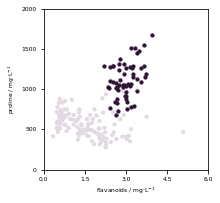

In [8]:
# Draw scatter plot.
fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
ax.scatter(data["Flavanoids"], data["Proline"], c=data["Class"], cmap=plt.cm.twilight, s=10, alpha=1.0)
ax.scatter(data[data["Class"] == 1]["Flavanoids"], data[data["Class"] == 1]["Proline"], color=plt.cm.twilight(0.5), s=10, alpha=1.0)
ax.set_xlim(0, 6)
ax.set_ylim(0, 2000)
ax.set_xlabel('flavanoids / mg$\cdot$L$^{-1}$')
ax.set_ylabel('proline / mg$\cdot$L$^{-1}$')
ax.set_xticks(np.round(np.linspace(0,6,5),2))
ax.set_yticks(np.round(np.linspace(0,2000,5),2))
plt.savefig('./figures/scatter',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

## Define model.

In [5]:
with pm.Model() as logistic_model:
    
    # Define priors.
    beta_0 = pm.Normal("intercept", 0, 1e6)
    beta_1 = pm.Normal("flavanoids", 0, 1e6)
    beta_2 = pm.Normal("proline", 0, 1e6)
    
    # Define posterior.
    p = pm.invlogit(beta_0 + beta_1*data["Flavanoids"] + beta_2*data["Proline"])
    y = pm.Bernoulli("y", p=p, observed=data["Class"])
    
    # Sample.
    trace = pm.sample(2000, tune=1000, init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proline, flavanoids, intercept]
Sampling 4 chains, 46 divergences: 100%|██████████| 12000/12000 [00:11<00:00, 1057.03draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7190249121763665, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


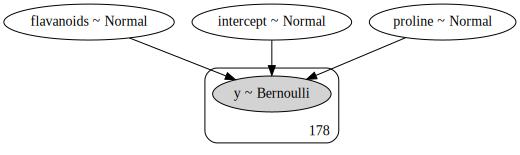

In [14]:
# Visualize graphical model.
pm.model_graph.model_to_graphviz(logistic_model)

## Check model.

### Estimated Bayesian Fraction of Missing Information (BFMI)
The Bayesian fraction of missing information of the model and trace. One element per chain in the trace.
The current advice is that values smaller than 0.3 indicate poor sampling.

In [25]:
print(*np.round(pm.stats.bfmi(trace),2))

1.01 1.02 1.1 1.19


### Summary

#### Highest Posterior Density (HPD)
The HPD is the minimum width Bayesian credible interval (BCI). This implementation works only for unimodal distributions.

#### Markov Chain Standard Error (MCSE) Statistic
The MCSE is the uncertainty added from the simulation due to small sample sizes.

#### Effective Sample Size ($\hat{N}_{eff}$)
The basic ess diagnostic is computed by 

$\hat{N}_{eff}$ = $\dfrac{MN}{\hat{\tau}}$

with $\hat{\tau}$ = -1 + 2 $\sum_{t=0}^K \hat{P}_{t}$, 
where $M$ is the number of chains, $N$ the number of draws, $\hat{\rho}_t$ is the estimated autocorrelation at lag $t$, and $K$ is the last integer for which $\hat{P}_K$ = $\hat{\rho}_K + \hat{\rho}_{K+1}$ is still positive.
The current implementation is similar to Stan, which uses Geyer’s initial monotone sequence criterion (Geyer, 1992; Geyer, 2011).

#### $\hat{R}$
The rank normalized $\hat{R}$ diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution. The diagnostic is computed by

$\hat{R} = \frac{\hat{V}}{W}$

where $W$ is the within-chain variance and $\hat{V}$ is the posterior variance estimate for the pooled rank-traces. This is the potential scale reduction factor, which converges to unity when each of the traces is a sample from the target posterior. Values greater than one indicate that one or more chains have not yet converged.

In [21]:
pm.stats.summary(trace, credible_interval=0.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,-20.350,4.355,-29.141,-12.335,0.122,0.086,1269.0,1269.0,1223.0,1221.0,1.0
flavanoids,2.391,0.661,1.141,3.704,0.016,0.012,1620.0,1620.0,1574.0,1438.0,1.0
proline,0.018,0.004,0.010,0.026,0.000,0.000,1443.0,1443.0,1428.0,1731.0,1.0


### Widely Available Information Criterion (WAIC)
**For model comparison**. A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.

In [7]:
pm.stats.waic(trace, pointwise=False, scale="deviance")

Computed from 8000 by 178 log-likelihood matrix

        Estimate       SE
IC_waic    40.28    12.30
p_waic      3.51        -

There has been a warning during the calculation. Please check the results.

### Pareto-Smoothed Importance Sampling Leave-One-Out Cross-Validation

**For model comparison**. Calculates leave-one-out (LOO) cross-validation for out of sample predictive model fit, following Vehtari et al. (2017). Cross-validation is computed using Pareto-smoothed importance sampling (PSIS).
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.

In [20]:
pm.stats.loo(trace, scale="log")

Computed from 8000 by 178 log-likelihood matrix

         Estimate       SE
elpd_loo   -20.33     6.21
p_loo        3.71        -

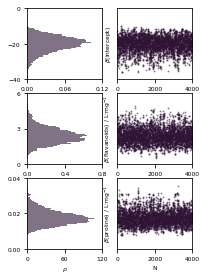

In [8]:
# Plot traces.
n_v = len(trace.varnames)
limits_x = [(0.0, 0.12), (0.0, 0.8), (0.0, 120)]
limits_y = [(-40, 0), (0, 6), (0.0, 0.04)] 
labels = ["", " / L$\cdot$mg$^{-1}$", " / L$\cdot$mg$^{-1}$"]
fig, axes = plt.subplots(figsize=(2.95, 0.5*n_v*2.95), ncols=2, nrows=n_v)
ax = axes.ravel()
for k in range(n_v):
    ax[2*k].hist(trace[trace.varnames[k]], orientation="horizontal", density=True, bins=50, color=plt.cm.twilight(0.5), alpha=0.6)
    ax[2*k+1].plot(trace[trace.varnames[k]], ".", ms=2, color=plt.cm.twilight(0.5), alpha=0.4)
    ax[2*k+1].set_ylabel(r"$\beta$"+"("+trace.varnames[k].lower()+")"+labels[k])
    ax[2*k+1].set_yticks(())
    ax[2*k+1].set_xlim((0, 4000))
    ax[2*k+1].set_xticks((0, 2000, 4000))
    ax[2*k].set_xlim(limits_x[k])
    ax[2*k].set_xticks(np.linspace(limits_x[k][0], limits_x[k][1], 3))
    ax[2*k].set_ylim(limits_y[k])
    ax[2*k].set_yticks(np.linspace(limits_y[k][0], limits_y[k][1], 3))
    ax[2*k+1].set_ylim(limits_y[k])
    #ax[2*k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[2*k].set_xlabel(r"$\rho$")
ax[2*k+1].set_xlabel(r"N")
plt.savefig('./figures/beta_trace',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

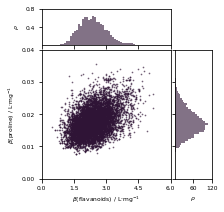

In [9]:
# Plot parameter distribution.
fig = plt.figure(figsize=(1.0*2.95, 1.0*2.95))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax.set_xlim(0, 6)
ax.set_ylim(0, 0.04)
ax.set_xlabel(r"$\beta$"+"("+trace.varnames[1].lower()+")"+" / L$\cdot$mg$^{-1}$")
ax.set_ylabel(r"$\beta$"+"("+trace.varnames[2].lower()+")"+" / L$\cdot$mg$^{-1}$")
ax.set_yticks((0.0, 0.01, 0.02, 0.03, 0.04))
ax.set_xticks((0.0, 1.5, 3.0, 4.5, 6.0))
ax_histx.set_ylim(0, 0.8)
ax_histx.set_ylabel(r"$\rho$")
ax_histx.set_yticks((0.4, 0.8))
ax_histy.set_xlim(0, 120)
ax_histy.set_xticks((60, 120))
ax_histy.set_xlabel(r"$\rho$")
scatter_hist(trace[trace.varnames[1]], trace[trace.varnames[2]], ax, ax_histx, ax_histy, color=plt.cm.twilight(0.5))
plt.savefig('./figures/beta_scatter',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

## Examine posterior predicitve distribution.

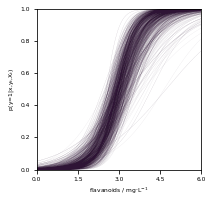

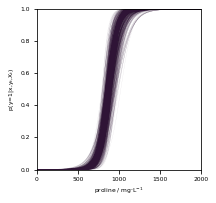

In [10]:
# Plot predictions (with uncertainty).
def linear_model(trace, flavanoids, proline):
    return 1 / (1 + np.exp(-(trace['intercept'] +
                             trace['flavanoids']*flavanoids +
                             trace['proline']*proline)))

lm = lambda x, samples: linear_model(samples, x, data["Proline"].mean())

lm1 = lambda x, samples: linear_model(samples, data["Flavanoids"].mean(), x)

plt.figure(figsize=(2.95, 2.95))
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(0, 6, 500), lm=lm, samples=1000, lw=0.2, color=plt.cm.twilight(0.5), alpha=0.15)
plt.title(label=None)
plt.xlabel("flavanoids / mg$\cdot$L$^{-1}$")
plt.ylabel(r"p(y=1|x,y$_t$,X$_t$)")
plt.xlim((0, 6))
plt.xticks((0.0,1.5,3.0,4.5,6.0))
plt.ylim((0, 1))
plt.savefig('./figures/prediction_flavanoid',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

plt.figure(figsize=(2.95, 2.95))
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(0, 2000, 500), lm=lm1, samples=1000, lw=0.2, color=plt.cm.twilight(0.5), alpha=0.15)
plt.title(label=None)
plt.xlabel("proline / mg$\cdot$L$^{-1}$")
plt.ylabel(r"p(y=1|x,y$_t$,X$_t$)")
plt.xlim((0, 2000))
plt.xticks((0,500,1000,1500,2000))
plt.ylim((0, 1))
plt.savefig('./figures/prediction_proline',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

### Odds Ratio
Two events are independent if and only if the odds ratio (OR) equals 1, i.e., the odds of one event are the same in either the presence or absence of the other event. If the OR is greater than 1, then A and B are associated (correlated) in the sense that, compared to the absence of B, the presence of B raises the odds of A, and symmetrically the presence of A raises the odds of B. Conversely, if the OR is less than 1, then A and B are negatively correlated, and the presence of one event reduces the odds of the other event. 

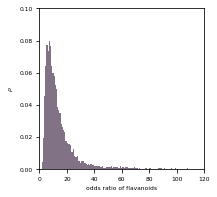

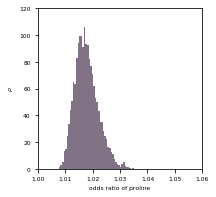

In [29]:
# Plot odds ratios.
plt.figure(figsize=(2.95, 2.95))
plt.hist(np.exp(trace["flavanoids"]), bins=200, density=True, color=plt.cm.twilight(0.5), alpha=0.6)
plt.xlim(0, 120)
plt.ylim(0, 0.10)
plt.xlabel("odds ratio of flavanoids")
plt.ylabel(r"$\rho$")
plt.savefig('./figures/odds_flavanoid',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

# Plot odds ratios.
plt.figure(figsize=(2.95, 2.95))
plt.hist(np.exp(trace["proline"]), bins=50, density=True, color=plt.cm.twilight(0.5), alpha=0.6)
plt.xlim(1.0, 1.06)
plt.ylim(0, 120)
plt.xlabel("odds ratio of proline")
plt.ylabel(r"$\rho$")
plt.savefig('./figures/odds_proline',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

## Predict new samples.

The expected probability is 0.97
The 95% credible interval is between 0.87 1.0


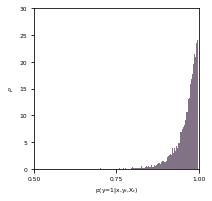

In [30]:
flavanoids = 2.55
proline = 1022.00
y_pred = linear_model(trace, flavanoids, proline)

print("The expected probability is", np.round(np.median(y_pred), 2))
print("The 95% credible interval is between", *np.round(np.quantile(y_pred, [0.025, 0.975]), 2))

plt.figure(figsize=(2.95, 2.95))
plt.hist(y_pred, bins=100, density=True, color=plt.cm.twilight(0.5), alpha=0.6)
plt.xlim(0.5, 1.0)
plt.xticks((0.5, 0.75, 1.0))
plt.ylim(0, 30)
plt.xlabel(r"p(y=1|x,y$_t$,X$_t$)")
plt.ylabel(r"$\rho$")
plt.savefig('./figures/prediction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

The expected probability is 0.85
The 95% credible interval is between 0.39 0.99


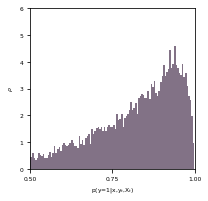

In [13]:
flavanoids = 1.5
proline = 1051.00
y_pred = linear_model(trace, flavanoids, proline)

print("The expected probability is", np.round(np.median(y_pred), 2))
print("The 95% credible interval is between", *np.round(np.quantile(y_pred, [0.025, 0.975]), 2))

plt.figure(figsize=(2.95, 2.95))
plt.hist(y_pred, bins=200, density=True, color=plt.cm.twilight(0.5), alpha=0.6)
plt.xlim(0.5, 1.0)
plt.xticks((0.5, 0.75, 1.0))
plt.ylim(0, 6)
plt.xlabel(r"p(y=1|x,y$_t$,X$_t$)")
plt.ylabel(r"$\rho$")
plt.savefig('./figures/prediction2',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()